In [1441]:
import numpy as np
import pandas as pd
from sklearn import metrics
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from keras.callbacks import EarlyStopping , ReduceLROnPlateau , ModelCheckpoint
from keras.models import load_model
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.2f}'.format

import tensorflow as tf
print(tf.__version__)

1.15.0


In [1442]:
epochs=300
batch_size=600

learning_rate = 1e-3
decay = learning_rate / epochs

patience=80

test_split = 0.1
validation_split = 0.2

select_features=True

SCALE_TARGET = True
SCALE_FEATURES = True

RUN_MODEL = True


In [1443]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'
models_dir = home_dir + "/models/"

data_file = 'orders_flow_data.csv'   # raw data as is
#data_file = 'order_flow_cleanup_data.csv'
#data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


In [1444]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [1445]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
0,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.07,1.00,1.00,1.00,1.00,1.00,1.00,2.50,0.15,0.24
1,0.06,0.02,0.02,0.02,0.02,0.01,0.01,0.18,0.18,1.00,1.00,1.00,1.00,1.00,1.00,1.89,0.15,0.24
2,0.07,0.03,0.02,0.03,0.02,0.01,0.01,0.44,0.20,1.00,1.00,1.00,1.00,1.00,1.00,1.35,0.15,0.24
3,0.07,0.03,0.02,0.02,0.02,0.01,0.01,0.23,0.17,1.00,1.00,1.00,1.00,1.00,1.00,1.26,0.13,0.24
4,0.07,0.02,0.01,0.02,0.02,0.01,0.01,0.24,0.14,1.00,1.00,1.00,1.00,1.00,1.00,1.28,0.36,0.24


In [1446]:
data.shape

(6766, 18)

# clear noice from outliers

In [1447]:
df = data

In [1448]:
df.describe(include="all")

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
count,"6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00"
mean,0.83,0.21,0.02,0.20,0.12,0.05,0.03,0.53,1.83,2.76,2.76,2.76,2.76,2.76,2.76,4.10,5.03,2.97
std,0.62,0.13,0.00,0.13,0.08,0.04,0.01,0.58,1.99,1.10,1.09,1.09,1.09,1.09,1.09,2.08,4.20,3.51
min,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.01,0.50,1.00,1.00,1.00,1.00,1.00,1.10,0.00,0.02
25%,0.19,0.08,0.02,0.05,0.03,0.04,0.02,0.12,0.02,2.00,2.00,2.00,2.00,2.00,2.00,1.92,0.49,0.24
50%,0.84,0.22,0.02,0.20,0.12,0.05,0.03,0.32,1.15,3.00,3.00,3.00,3.00,3.00,3.00,4.21,5.14,0.49
75%,1.29,0.30,0.02,0.30,0.18,0.06,0.04,0.58,3.28,4.00,4.00,4.00,4.00,4.00,4.00,5.78,8.20,5.81
max,2.73,0.91,0.04,0.64,0.34,0.63,0.10,2.53,6.58,4.00,4.00,4.00,4.00,4.00,4.00,9.66,20.13,9.75


shape before (6766, 18)
latency quantiles min 7.43360448807854 max 0.49
shape after (2014, 18)


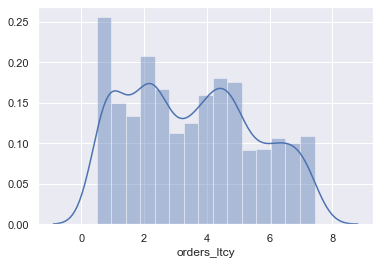

In [1449]:
df = data
print('shape before {}'.format(df.shape))
if 1 == 1:
    minq = df['orders_ltcy'].quantile(0.5)
    maxq = df['orders_ltcy'].quantile(0.8)
    print('latency quantiles min {} max {}'.format(maxq, minq))
    df = df[df['orders_ltcy'] > minq]
    df = df[df['orders_ltcy'] < maxq]
    sns.distplot(df['orders_ltcy'])
print('shape after {}'.format(df.shape)) 

In [1450]:
data = df
data.shape

(2014, 18)

# Shuffle the data

In [1451]:
# shuffle the data
from sklearn.utils import shuffle
data = shuffle(data, random_state=0)
print('shape {}'.format(data.shape))
data.head(5)

shape (2014, 18)


,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
5232,0.04,0.05,0.02,0.04,0.02,0.05,0.04,0.05,0.02,4.00,4.00,4.00,4.00,4.00,4.00,1.36,0.00,3.61
5436,0.04,0.05,0.02,0.04,0.02,0.05,0.04,0.05,0.02,4.00,4.00,4.00,4.00,4.00,4.00,1.36,0.00,2.32
5305,0.04,0.05,0.02,0.04,0.02,0.05,0.04,0.05,0.02,4.00,4.00,4.00,4.00,4.00,4.00,1.36,0.00,3.15
5608,0.04,0.05,0.02,0.04,0.02,0.05,0.04,0.05,0.02,4.00,4.00,4.00,4.00,4.00,4.00,1.36,0.00,1.23
5287,0.04,0.05,0.02,0.04,0.02,0.05,0.04,0.05,0.02,4.00,4.00,4.00,4.00,4.00,4.00,1.36,0.00,3.26


In [1452]:
x_data = data.drop(['orders_ltcy'], axis=1)
x_data = x_data.values
print("Shape x_data: ", x_data.shape)
print("type x_data: ", type(x_data))

y_data = data['orders_ltcy'].values
y_data = y_data.reshape(-1,1)
print("Shape y_data: ", y_data.shape)
print("type y_data: ", type(y_data))

num_data = len(x_data)
print("There are {} sample data".format(num_data))

Shape x_data:  (2014, 17)
type x_data:  <class 'numpy.ndarray'>
Shape y_data:  (2014, 1)
type y_data:  <class 'numpy.ndarray'>
There are 2014 sample data


In [1453]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

if SCALE_FEATURES:
    x_scaler = StandardScaler()  # StandardScaler() or MinMaxScaler()
    x_data = x_scaler.fit_transform(x_data)

In [1454]:
if SCALE_TARGET:
    y_scaler =  MinMaxScaler() # StandardScaler()
    y_data = y_scaler.fit_transform(y_data)

In [1455]:
x_dataset = np.expand_dims(x_data, axis=2)
n_depth = x_dataset.shape[1]
n_width = x_dataset.shape[2]
x_dataset.shape

(2014, 17, 1)

In [1456]:
y_dataset = y_data.reshape(y_data.shape[0])
n_targets = y_data.shape[1]
y_dataset.shape

(2014,)

In [1457]:

print('Experiment has {} number of features and {} number of target(s)'.format(n_depth,n_targets))


Experiment has 17 number of features and 1 number of target(s)


In [1458]:
validate_split = 0.1
test_split = 0.1
train_split = 1 - (test_split + validate_split)

num_data = len(x_dataset)

num_test = int(test_split * num_data)
num_validate = int(validate_split * num_data)
num_train = num_data - (num_test + num_validate)
print('Data splitted to training {} , validation {} and testing {}'.format(num_train, num_validate, num_test))

Data splitted to training 1612 , validation 201 and testing 201


In [1459]:
x_train = x_dataset[:num_train]
x_validate = x_dataset[num_train:num_train+num_validate]
x_test = x_dataset[num_train+num_validate:]

print("x_train {} , x_validate {} , x_test {}".format(x_train.shape, x_validate.shape, x_test.shape))

len(x_train) + len(x_validate) + len(x_test)

x_train (1612, 17, 1) , x_validate (201, 17, 1) , x_test (201, 17, 1)


2014

In [1460]:
y_train = y_dataset[:num_train]
y_validate = y_dataset[num_train:num_train+num_validate]
y_test = y_dataset[num_train+num_validate:]

print("y_train {} , y_validate {} , y_test {}".format(y_train.shape, y_validate.shape, y_test.shape))

len(y_train) + len(y_validate) + len(y_test)

y_train (1612,) , y_validate (201,) , y_test (201,)


2014

In [1461]:
print('y_test shape {}'.format(y_test.shape))
y_test[0:10]

y_test shape (201,)


array([0.00639018, 0.73852224, 0.20279142, 0.43777333, 0.49386963,
       0.46804708, 0.34598261, 0.55310188, 0.70291981, 0.420839  ])

In [1462]:
# data batch generator
def batch_generator(batch_size, sequence_length=n_depth, n_features=n_width):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, n_features)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        #y_shape = (batch_size, sequence_length, num_y_signals)
        #y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        y_batch = []

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train[idx]
            y_batch.append(y_train[idx])
        
        yield (x_batch, np.array(y_batch))

In [1463]:
generator = batch_generator(batch_size)

In [1464]:
# test the batch generator
if 1 == 1:
    x_batch, y_batch = next(generator)
    print(x_batch.shape)
    print(y_batch.shape)

(600, 17, 1)
(600,)


In [1465]:
# test and validate tuples
test_data = (x_test, y_test)
validate_data = (x_validate, y_validate)

In [1466]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import RMSprop, Adam
from keras import models
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [1467]:
# 1-D CONV CNN for feature recognition
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, kernel_initializer='normal', activation='relu', input_shape=(n_depth,n_width)))
model.add(Conv1D(filters=64, kernel_size=3, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(200, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(n_targets, kernel_initializer='normal', activation='linear'))

adam = Adam(lr=learning_rate, decay=decay)
# or loss= 'mean_absolute_percentage_error'
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_107 (Conv1D)          (None, 15, 64)            256       
_________________________________________________________________
conv1d_108 (Conv1D)          (None, 13, 64)            12352     
_________________________________________________________________
dropout_53 (Dropout)         (None, 13, 64)            0         
_________________________________________________________________
max_pooling1d_53 (MaxPooling (None, 6, 64)             0         
_________________________________________________________________
flatten_50 (Flatten)         (None, 384)               0         
_________________________________________________________________
dense_225 (Dense)            (None, 200)               77000     
_________________________________________________________________
dense_226 (Dense)            (None, 100)               20100     
__________

In [1468]:
# call backs
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

# save the best model only
path_model = models_dir + 'best_mlp_model.h5'
mc = ModelCheckpoint(path_model
                     , monitor='val_loss'
                     , mode='min' 
                     , verbose=1
                     #, save_weights_only=True
                     , save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [es, mc, reduce_lr]

In [1469]:
%%time
steps_per_epoch = int(num_train / batch_size)   # = total number of training data points divided by the batch size

if RUN_MODEL:
    history = model.fit_generator(generator=generator,epochs=epochs
                                  ,steps_per_epoch=steps_per_epoch
                                  ,validation_data=validate_data
                                  ,callbacks=callbacks,verbose=1,shuffle=False)
    #history = model.fit(x_train, y_train, epochs=epochs
                        #, verbose=1,callbacks=callbacks,shuffle=True,validation_data=validate_data)
    
    

Epoch 1/300
2/2 [==============================] - 11s 5s/step - loss: 0.2652 - mean_squared_error: 0.2652 - val_loss: 0.2791 - val_mean_squared_error: 0.2791

Epoch 00001: val_loss improved from inf to 0.27913, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 2/300
2/2 [==============================] - 0s 59ms/step - loss: 0.2536 - mean_squared_error: 0.2536 - val_loss: 0.2665 - val_mean_squared_error: 0.2665

Epoch 00002: val_loss improved from 0.27913 to 0.26651, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 3/300
2/2 [==============================] - 0s 63ms/step - loss: 0.2407 - mean_squared_error: 0.2407 - val_loss: 0.2446 - val_mean_squared_error: 0.2446

Epoch 00003: val_loss improved from 0.26651 to 0.24458, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 4/300
2/2 [==============================] - 0s 62m

2/2 [==============================] - 0s 61ms/step - loss: 0.0778 - mean_squared_error: 0.0778 - val_loss: 0.0989 - val_mean_squared_error: 0.0989

Epoch 00030: val_loss did not improve from 0.09850
Epoch 31/300
2/2 [==============================] - 0s 62ms/step - loss: 0.0835 - mean_squared_error: 0.0835 - val_loss: 0.0992 - val_mean_squared_error: 0.0992

Epoch 00031: val_loss did not improve from 0.09850
Epoch 32/300
2/2 [==============================] - 0s 67ms/step - loss: 0.0781 - mean_squared_error: 0.0781 - val_loss: 0.0995 - val_mean_squared_error: 0.0995

Epoch 00032: val_loss did not improve from 0.09850
Epoch 33/300
2/2 [==============================] - 0s 64ms/step - loss: 0.0787 - mean_squared_error: 0.0787 - val_loss: 0.0998 - val_mean_squared_error: 0.0998

Epoch 00033: val_loss did not improve from 0.09850
Epoch 34/300
2/2 [==============================] - 0s 66ms/step - loss: 0.0818 - mean_squared_error: 0.0818 - val_loss: 0.1000 - val_mean_squared_error: 0.1000


2/2 [==============================] - 0s 67ms/step - loss: 0.0806 - mean_squared_error: 0.0806 - val_loss: 0.0946 - val_mean_squared_error: 0.0946

Epoch 00062: val_loss improved from 0.09471 to 0.09456, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 63/300
2/2 [==============================] - 0s 68ms/step - loss: 0.0747 - mean_squared_error: 0.0747 - val_loss: 0.0946 - val_mean_squared_error: 0.0946

Epoch 00063: val_loss did not improve from 0.09456
Epoch 64/300
2/2 [==============================] - 0s 66ms/step - loss: 0.0751 - mean_squared_error: 0.0751 - val_loss: 0.0946 - val_mean_squared_error: 0.0946

Epoch 00064: val_loss did not improve from 0.09456
Epoch 65/300
2/2 [==============================] - 0s 71ms/step - loss: 0.0744 - mean_squared_error: 0.0744 - val_loss: 0.0945 - val_mean_squared_error: 0.0945

Epoch 00065: val_loss improved from 0.09456 to 0.09448, saving model to /Users/hmohamed/github/data-research


Epoch 00095: val_loss did not improve from 0.09230
Epoch 96/300
2/2 [==============================] - 0s 63ms/step - loss: 0.0743 - mean_squared_error: 0.0743 - val_loss: 0.0930 - val_mean_squared_error: 0.0930

Epoch 00096: val_loss did not improve from 0.09230
Epoch 97/300
2/2 [==============================] - 0s 63ms/step - loss: 0.0747 - mean_squared_error: 0.0747 - val_loss: 0.0927 - val_mean_squared_error: 0.0927

Epoch 00097: val_loss did not improve from 0.09230
Epoch 98/300
2/2 [==============================] - 0s 62ms/step - loss: 0.0759 - mean_squared_error: 0.0759 - val_loss: 0.0924 - val_mean_squared_error: 0.0924

Epoch 00098: val_loss did not improve from 0.09230
Epoch 99/300
2/2 [==============================] - 0s 64ms/step - loss: 0.0727 - mean_squared_error: 0.0727 - val_loss: 0.0922 - val_mean_squared_error: 0.0922

Epoch 00099: val_loss improved from 0.09230 to 0.09219, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_m


Epoch 00129: val_loss did not improve from 0.09113
Epoch 130/300
2/2 [==============================] - 0s 63ms/step - loss: 0.0722 - mean_squared_error: 0.0722 - val_loss: 0.0923 - val_mean_squared_error: 0.0923

Epoch 00130: val_loss did not improve from 0.09113
Epoch 131/300
2/2 [==============================] - 0s 65ms/step - loss: 0.0709 - mean_squared_error: 0.0709 - val_loss: 0.0926 - val_mean_squared_error: 0.0926

Epoch 00131: val_loss did not improve from 0.09113
Epoch 132/300
2/2 [==============================] - 0s 64ms/step - loss: 0.0727 - mean_squared_error: 0.0727 - val_loss: 0.0923 - val_mean_squared_error: 0.0923

Epoch 00132: val_loss did not improve from 0.09113
Epoch 133/300
2/2 [==============================] - 0s 62ms/step - loss: 0.0700 - mean_squared_error: 0.0700 - val_loss: 0.0920 - val_mean_squared_error: 0.0920

Epoch 00133: val_loss did not improve from 0.09113
Epoch 134/300
2/2 [==============================] - 0s 63ms/step - loss: 0.0708 - mean_squa

2/2 [==============================] - 0s 67ms/step - loss: 0.0693 - mean_squared_error: 0.0693 - val_loss: 0.0899 - val_mean_squared_error: 0.0899

Epoch 00164: val_loss did not improve from 0.08975
Epoch 165/300
2/2 [==============================] - 0s 64ms/step - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 0.0897 - val_mean_squared_error: 0.0897

Epoch 00165: val_loss improved from 0.08975 to 0.08973, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 166/300
2/2 [==============================] - 0s 67ms/step - loss: 0.0737 - mean_squared_error: 0.0737 - val_loss: 0.0893 - val_mean_squared_error: 0.0893

Epoch 00166: val_loss improved from 0.08973 to 0.08930, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 167/300
2/2 [==============================] - 0s 67ms/step - loss: 0.0723 - mean_squared_error: 0.0723 - val_loss: 0.0889 - val_mean_squared_error: 0.0889

E

2/2 [==============================] - 0s 65ms/step - loss: 0.0661 - mean_squared_error: 0.0661 - val_loss: 0.0890 - val_mean_squared_error: 0.0890

Epoch 00200: val_loss did not improve from 0.08858
Epoch 201/300
2/2 [==============================] - 0s 65ms/step - loss: 0.0696 - mean_squared_error: 0.0696 - val_loss: 0.0892 - val_mean_squared_error: 0.0892

Epoch 00201: val_loss did not improve from 0.08858
Epoch 202/300
2/2 [==============================] - 0s 65ms/step - loss: 0.0679 - mean_squared_error: 0.0679 - val_loss: 0.0895 - val_mean_squared_error: 0.0895

Epoch 00202: val_loss did not improve from 0.08858
Epoch 203/300
2/2 [==============================] - 0s 65ms/step - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0897 - val_mean_squared_error: 0.0897

Epoch 00203: val_loss did not improve from 0.08858
Epoch 204/300
2/2 [==============================] - 0s 65ms/step - loss: 0.0703 - mean_squared_error: 0.0703 - val_loss: 0.0905 - val_mean_squared_error: 0.0

2/2 [==============================] - 0s 69ms/step - loss: 0.0694 - mean_squared_error: 0.0694 - val_loss: 0.0903 - val_mean_squared_error: 0.0903

Epoch 00236: val_loss did not improve from 0.08767
Epoch 237/300
2/2 [==============================] - 0s 65ms/step - loss: 0.0677 - mean_squared_error: 0.0677 - val_loss: 0.0897 - val_mean_squared_error: 0.0897

Epoch 00237: val_loss did not improve from 0.08767
Epoch 238/300
2/2 [==============================] - 0s 66ms/step - loss: 0.0657 - mean_squared_error: 0.0657 - val_loss: 0.0892 - val_mean_squared_error: 0.0892

Epoch 00238: val_loss did not improve from 0.08767
Epoch 239/300
2/2 [==============================] - 0s 65ms/step - loss: 0.0691 - mean_squared_error: 0.0691 - val_loss: 0.0888 - val_mean_squared_error: 0.0888

Epoch 00239: val_loss did not improve from 0.08767
Epoch 240/300
2/2 [==============================] - 0s 66ms/step - loss: 0.0694 - mean_squared_error: 0.0694 - val_loss: 0.0886 - val_mean_squared_error: 0.0

2/2 [==============================] - 0s 67ms/step - loss: 0.0703 - mean_squared_error: 0.0703 - val_loss: 0.0901 - val_mean_squared_error: 0.0901

Epoch 00273: val_loss did not improve from 0.08723
Epoch 274/300
2/2 [==============================] - 0s 67ms/step - loss: 0.0734 - mean_squared_error: 0.0734 - val_loss: 0.0904 - val_mean_squared_error: 0.0904

Epoch 00274: val_loss did not improve from 0.08723
Epoch 275/300
2/2 [==============================] - 0s 66ms/step - loss: 0.0669 - mean_squared_error: 0.0669 - val_loss: 0.0902 - val_mean_squared_error: 0.0902

Epoch 00275: val_loss did not improve from 0.08723
Epoch 276/300
2/2 [==============================] - 0s 70ms/step - loss: 0.0700 - mean_squared_error: 0.0700 - val_loss: 0.0892 - val_mean_squared_error: 0.0892

Epoch 00276: val_loss did not improve from 0.08723
Epoch 277/300
2/2 [==============================] - 0s 70ms/step - loss: 0.0662 - mean_squared_error: 0.0662 - val_loss: 0.0881 - val_mean_squared_error: 0.0

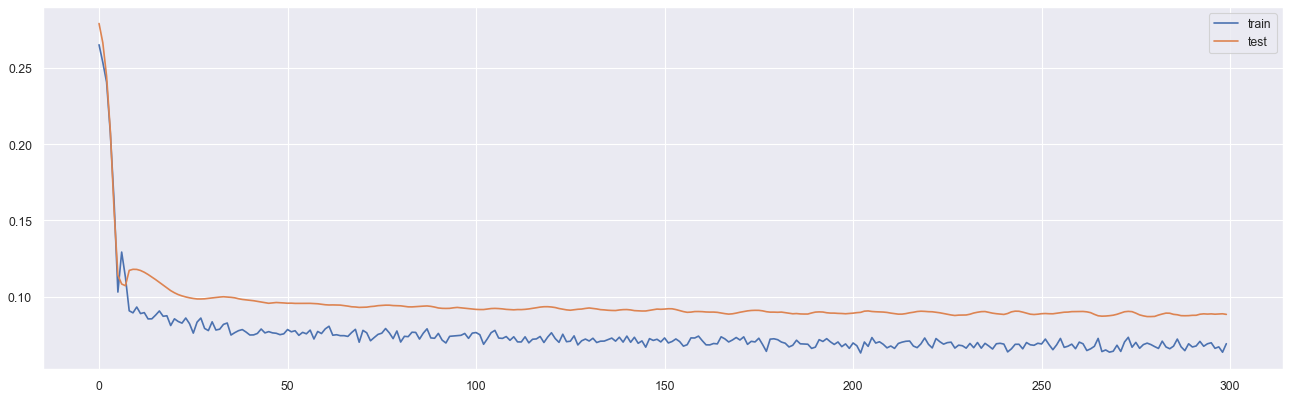

In [1470]:
# plot history
if RUN_MODEL:
    plt.figure(figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

In [1471]:
val_loss = history.history['val_loss']
val_loss_df = pd.DataFrame(val_loss)

print("Model Validation MSE mean: %.2f  std: (%.2f)" % \
      (val_loss_df.mean(), val_loss_df.std()))


Model Validation MSE mean: 0.09  std: (0.02)


In [1472]:
# Load the best saved model
try:
    model = models.load_model(path_model)
except Exception as error:
    print("Error trying to load model.")
    print(error)
    

# Plot Prediction

In [1476]:
def y_comparison(start_idx, length=100, target_scaled=True, data_set='train'):
    """
    Obtain predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if data_set == 'train':
        # Use training-data.
        x = x_train
        y_true = y_train
    elif data_set == 'validate':
        x = x_validate
        y_true = y_validate
    else:
        # Use test-data.
        x = x_test
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    #x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    if target_scaled:
        # The output of the model is scaled.
        # Do an inverse map to get it back to the scale
        # of the original data-set.
        y_pred = y_scaler.inverse_transform(y_pred)
    
    print("shape y_pred: %", y_pred.shape)
    print("shape y_true: %", y_true.shape)
    
    return y_true, y_pred


#This helper-function plots the predicted and true output-signals.
def plot_comparison(signal_true, signal_pred):
    """
    Plot the predicted and true output-signals.
    """

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))
        
    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')
        
    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
    # Plot labels etc.
    plt.ylabel('ltcy')
    plt.legend()
    plt.show()

# Check on Some Training Data

Let us start with an example from the training-data. This is data that the model has seen during training so it should perform reasonably well on this data.

In [1477]:
print("total number of training targets {}".format(num_train))
train_signal_true, train_signal_pred = y_comparison(start_idx=0, length=num_train
                                                    , target_scaled=SCALE_TARGET, data_set='train')
train_signal_pred.shape

total number of training targets 1612
shape y_pred: % (1612, 1)
shape y_true: % (1612,)


(1612, 1)

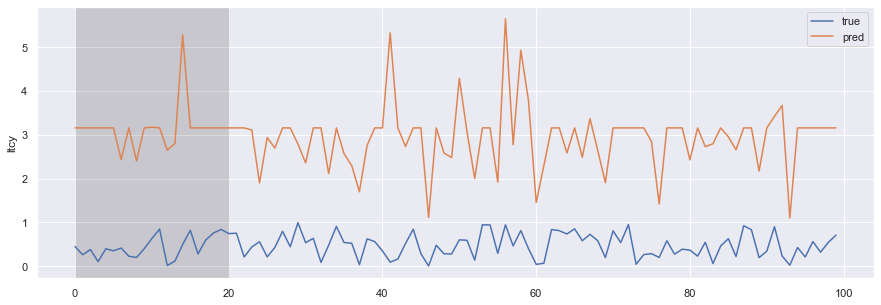

In [1478]:
plot_comparison(train_signal_true[10:110], train_signal_pred[10:110])

In [1479]:
import math

train_signal_pred.reshape(train_signal_pred.shape[0])

print('shape y test {}'.format(train_signal_true.shape))
print('shape y predicted {}'.format(train_signal_pred.shape))

#print ("Actual train values: \n {}".format(train_signal_true[:20]))
#print ("Predicted train values: \n {}".format(train_signal_pred[:20]))

print("")
# calculate RMSE
rmse = math.sqrt(mean_squared_error(train_signal_true, train_signal_pred))
print('Train RMSE: %.3f' % rmse)

shape y test (1612,)
shape y predicted (1612, 1)

Train RMSE: 2.529


<function matplotlib.pyplot.show(*args, **kw)>

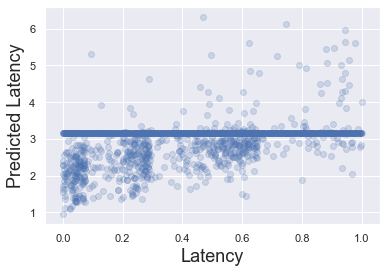

In [1480]:
plt.scatter(train_signal_true, train_signal_pred, alpha=0.2)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

In [1481]:
r2_train = metrics.r2_score(train_signal_true, train_signal_pred)
print('R2 (training) = {}'.format(r2_train))

R2 (training) = -78.34783747044453


# Evaluate Model

In [1482]:
print("total number of testing targets {}".format(num_test))
test_signal_true, test_signal_pred = y_comparison(start_idx=0, length=num_test
                                                    , target_scaled=SCALE_TARGET, data_set='test')

total number of testing targets 201
shape y_pred: % (201, 1)
shape y_true: % (201,)


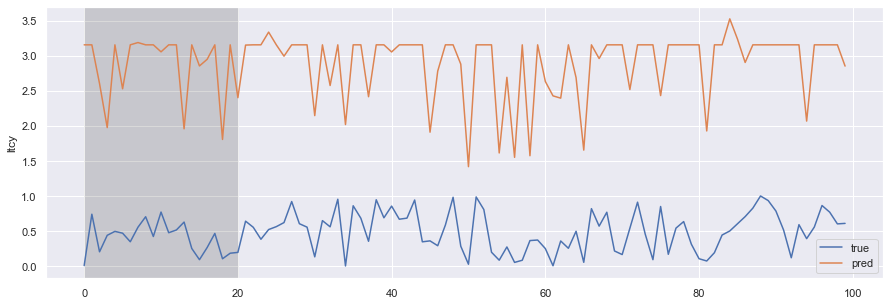

In [1483]:
plot_comparison(test_signal_true[:100], test_signal_pred[:100])

# *** R2

In [1484]:
r2_test = metrics.r2_score(test_signal_true[:100], test_signal_pred[:100])
print('R2 (testing) = {}'.format(r2_test))

R2 (testing) = -77.75285414576648


Text(0.5, 1.0, 'Residual PDF')

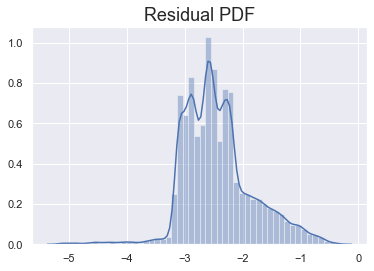

In [1485]:
sns.distplot(test_signal_true - test_signal_pred)
plt.title('Residual PDF', size=18)

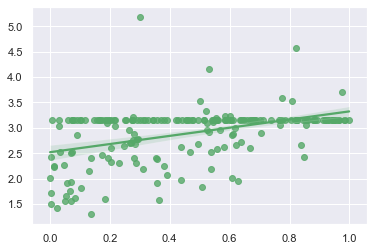

In [1486]:
ax = sns.regplot(x=test_signal_true, y=test_signal_pred, color='g')

<function matplotlib.pyplot.show(*args, **kw)>

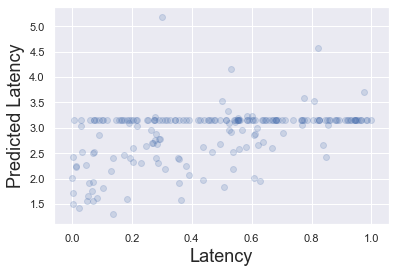

In [1487]:
plt.scatter(test_signal_true, test_signal_pred, alpha=0.2)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

In [1488]:
print('shape y test {}'.format(test_signal_true.shape))
print('shape y predicted {}'.format(test_signal_pred.shape))

#print ("Actual test values: \n {}".format(test_signal_true[:20]))
#print ("Predicted test values: \n {}".format(test_signal_pred[:20]))

print("")
# calculate RMSE
rmse = math.sqrt(mean_squared_error(test_signal_true, test_signal_pred))
print('Test RMSE: %.3f' % rmse)

shape y test (201,)
shape y predicted (201, 1)

Test RMSE: 2.474


In [1489]:
# df['f'] = df['d'].rolling(2).sum().shift(-1)

print(test_signal_true.shape)
print(test_signal_pred.shape)

true_df = round(pd.DataFrame(test_signal_true, columns=['actual']),2)
pred_df = round(pd.DataFrame(test_signal_pred, columns=['predicted']),2)


compare_df = pd.concat([true_df,pred_df], axis=1, sort=False)

# testing mean_absolute_percentage_error
compare_df['residual'] = round(compare_df['actual'] - compare_df['predicted'], 2)
compare_df['difference%'] = round(np.absolute(compare_df['residual']* 100 / compare_df['actual']),2)

compare_df.head(5)

(201,)
(201, 1)


,actual,predicted,residual,difference%
0,0.01,3.15,-3.14,"31,400.00"
1,0.74,3.15,-2.41,325.68
2,0.20,2.60,-2.40,"1,200.00"
3,0.44,1.97,-1.53,347.73
4,0.49,3.15,-2.66,542.86


In [1490]:
compare_df.describe()

,actual,predicted,residual,difference%
count,201.00,201.00,201.00,201.00
mean,0.47,2.89,-2.43,inf
std,0.29,0.53,0.48,nan
min,0.00,1.31,-4.88,185.88
25%,0.22,2.66,-2.72,336.11
50%,0.49,3.15,-2.44,493.18
75%,0.68,3.15,-2.20,"1,160.00"
max,1.00,5.18,-1.17,inf


In [1491]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
compare_df.sort_values(by = ['difference%'])

,actual,predicted,residual,difference%
75,0.85,2.43,-1.58,185.88
13,0.63,1.96,-1.33,211.11
88,1.00,3.15,-2.15,215.00
169,0.84,2.66,-1.82,216.67
51,0.99,3.15,-2.16,218.18
48,0.98,3.15,-2.17,221.43
166,0.97,3.15,-2.18,224.74
168,0.61,2.00,-1.39,227.87
130,0.96,3.15,-2.19,228.12
195,0.96,3.15,-2.19,228.12


In [1492]:
print("... FINISH ....")

... FINISH ....
